In [2]:
# # aws dependencies
# %pip install awswrangler

# # guara dependencies
# %pip install lightgbm
# %pip install shap
# %pip install optuna
# %pip install great_expectations
# %pip install unidecode

In [3]:
# general libs
import os
import re
import sys
import nltk 
import heapq
import boto3
import string
import difflib
import sagemaker
import numpy as np 
import pandas as pd
import seaborn as sn
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('punkt')

# guara libs
from sklearn.pipeline import Pipeline
sys.path.append(os.path.dirname(os.getcwd())+'/src')
from guara.modeling.supervised_modelz import SupervisedModelz

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load data

In [4]:
# carregar dataset Laudo_classificacao_2020.xlsx como df
df =  wr.s3.read_excel(path='s3://br-accamargo-rawdata-dev/Laudo_classificacao_2020.xlsx', engine='openpyxl')
df.columns = df.columns.str.lower()
df.rename(columns={'(1) câncer / (2) não câncer':'cancer', 'texto_diagnostico_resumo':'resumo'}, inplace=True)

In [5]:
df.head()

,rgh,identificador,laudo,data,resumo,cancer
0,1341,3004888942H20-028890,H20-028890,2020-11-12,[* Pólipo endometrial sem atipias.],2
1,3166,3003664904H20-013662,H20-013662,2020-06-29,[*Adenocarcinoma endometrioide de endométrio c...,1
2,3166,2003793224H20-014936,H20-014936,2020-07-20,[* Adenocarcinoma endometrioide do endométrio ...,1
3,4448,3004533927H20-024222,H20-024222,2020-10-07,"[* Pólipo endocervical sem atipias., * Pólipo ...",2
4,6220,1003913311H20-016310,H20-016310,2020-07-31,[* Pólipo endocervical sem atipias com metapla...,2


In [6]:
# lendo datasets atualizados
laudos_list=[]

s3 = boto3.resource('s3', region_name='us-east-1', verify=False)
bucket = s3.Bucket('br-accamargo-rawdata-dev')

for files in bucket.objects.filter(Prefix='laudos_novo/LAUDOS'):
    laudos_list.append(wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/'+str(files.key)))

In [7]:
# concatenação dos datasets atualizados
laudos = pd.concat(laudos_list, axis=0)
laudos.columns = laudos.columns.str.lower()
laudos.rename(columns={'testodiagnosi':'texto','codigo_interno':'laudo'}, inplace=True)
laudos.drop_duplicates(inplace=True)
laudos.head()

,laudo,rgh,dataliberacao,descrizione,codice,texto,testodiagnosicitotec
0,H18-000071,15354940,04/01/2018,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Biópsia de pulmão: * Carcinoma epidermóide ...,<NA>
1,H18-000072,13832650,05/01/2018,BIOPSIA,BIO,1 Biópsia de lesão em amígdala direita: * P...,<NA>
2,H20-003157,13832650,04/02/2020,BIOPSIA,BIO,1 Biópsia de pele em peitoral esquerdo: * N...,<NA>
3,H18-000396,15360500,09/01/2018,BIOPSIA,BIO,1 Biópsia de pulmão direito: * Adenocarcino...,<NA>
4,H19-001989,15079600,31/01/2019,PEÇA CIRÚRGICA,PC,1 Esvaziamento cervical nível II B à direita ...,<NA>


<AxesSubplot:>

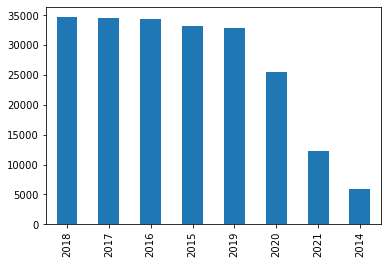

In [8]:
laudos.dataliberacao.apply(lambda x: x[-4:]).value_counts().plot(kind = 'bar')

In [9]:
# juntar df e laudos pela coluna laudo
full_df = pd.merge(left=df, right=laudos, on=['laudo'], how='inner')

In [10]:
# filtrar o dataframe: colunas = [df.id, laudo.laudo, df.rotulo]
full_df = full_df#[['laudo','texto','cancer']]
full_df['cancer'] = abs(full_df['cancer']-2)
full_df.head()

,rgh_x,identificador,laudo,data,resumo,cancer,rgh_y,dataliberacao,descrizione,codice,texto,testodiagnosicitotec
0,1341,3004888942H20-028890,H20-028890,2020-11-12,[* Pólipo endometrial sem atipias.],0,1341,12/11/2020,PEÇA CIRÚRGICA,PC,1 Biópsia de pólipo endometrial: * Pólipo end...,<NA>
1,3166,3003664904H20-013662,H20-013662,2020-06-29,[*Adenocarcinoma endometrioide de endométrio c...,1,3166,29/06/2020,REVISAO DE CASO (LAMINA) EXTERNO,REV_EXT,Biópsia de endométrio (SPA20-26515): *Adenoca...,<NA>
2,3166,2003793224H20-014936,H20-014936,2020-07-20,[* Adenocarcinoma endometrioide do endométrio ...,1,3166,20/07/2020,PER-OPERATÓRIO PEÇA CIRÚRGICA,CONG_PEÇA,Útero: Corpo uterino: * Adenocarcinoma endom...,<NA>
3,4448,3004533927H20-024222,H20-024222,2020-10-07,"[* Pólipo endocervical sem atipias., * Pólipo ...",0,4448,07/10/2020,PEÇA CIRÚRGICA,PC,1 Pólipo de canal endocervical: * Pólipo endo...,<NA>
4,6220,1003913311H20-016310,H20-016310,2020-07-31,[* Pólipo endocervical sem atipias com metapla...,0,6220,31/07/2020,PEÇA CIRÚRGICA,PC,1 Pólipo de canal endocervical: * Pólipo endo...,<NA>


In [11]:
full_df.data.dt.year.value_counts()

2020    6806
Name: data, dtype: int64

# Modelagem

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [13]:
import nltk
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.util import bigrams
from nltk.misc import babelize_shell
from unidecode import unidecode
from nltk import tokenize

def GetYearBasis(X, col='dataliberacao'):
    assert isinstance(X, pd.DataFrame)

    dataset_list = []
    for year in sorted(set(X[col].dt.year)):
        X_aux = X.copy()
        X_aux[col] = pd.to_datetime(X[col])
        X_aux = X_aux[X_aux[col].dt.year == year]
        dataset_list.append(X_aux)
        
    return dataset_list


def processa_texto_(texto, return_ = 'string'):
    # stemmer = nltk.stem.RSLPStemmer()
    stemmer = nltk.stem.SnowballStemmer(language = 'portuguese')
    stopwords=nltk.corpus.stopwords.words('portuguese')
   


    # separa em palavras
    token = tokenize.word_tokenize(texto.lower(), language='portuguese')
    # retira stopwords
    token = [word for word in token if word not in stopwords]
    # retira palavras pre selecionadas
    #token = [word for word in token if len(word) > 2]
    # retira numeros 
    token = [ word if word.isalpha() else '#NUM' for word in token ]
    # tira caracteres especiais  e faz stemmizacao
    token = [unidecode(stemmer.stem(word)) for word in token]

    if return_ == 'string':
        return ' '.join(token)
    elif return_ == 'list':
        return token

    
class ProcessaTexto(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        self.col=col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
     
        X['texto_tratado'] = X[self.col].replace('\§', ' ENTER ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '-'], '', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '\*'], ' ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace([ '\/', '\.', '\,', '\;'], ' punkt ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].apply(lambda x: processa_texto_(x))
        
        return X

In [14]:
class CountVectorizerPandas(BaseEstimator, TransformerMixin):
    """
    Performs bag of words on a column
    args:
        max_features: maximum number of features
    
    """  
    
    def __init__(self, max_features):
        self.cv = None
        self.max_features = max_features
        
    def fit(self, X, y=None):
        
        self.col = 'texto_tratado'
        
        self.cv =  CountVectorizer(max_features=self.max_features)
                           
        self.cv.fit(X[self.col])
        
        return self


    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        
        Xt = self.cv.transform(X[self.col]).todense()
        Xt = pd.DataFrame(Xt, columns = self.cv.get_feature_names(), index=X.index)
        
        return Xt  

In [15]:
# split dos dados - 70% para treino e 30% para validação
x_train, x_test, y_train, y_test = train_test_split(
    full_df[['laudo','texto']], 
    full_df['cancer'], 
    train_size=0.7, 
    shuffle=True,
    random_state=123
    )


# aplicar pipeline com transformações
pipe = Pipeline([
    ('preproc', ProcessaTexto('texto')),
    ('bag', CountVectorizerPandas(max_features=250))
])

x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

In [16]:
y_train.value_counts()/y_train.shape[0]

0    0.75
1    0.25
Name: cancer, dtype: float64

In [17]:
x_train.head()  

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
5130,0,0,0,0,0,0,2,0,0,0,...,0,1,2,0,0,0,0,0,0,0
2416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0
1300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
print('x_train shape: ', x_train.shape, 'y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ', y_test.shape)

x_train shape:  (4764, 250) y_train shape:  (4764,)
x_test shape:  (2042, 250) y_test shape:  (2042,)


In [19]:
# modelagem
md = SupervisedModelz('lgbm', 'binary')

params = {
    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu',
    'is_unbalanced':'true',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': 20,
    'n_estimators': 500,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
 }

model = md.fit(x_train, x_test, y_train, y_test, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 1191, number of negative: 3573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 4764, number of used features: 250
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
Modelo treinado em 0.01 minutos 



Model best iteration: 500

BINARY_LOGLOSS loss:
Train: 0.0481
Val  : 0.0545


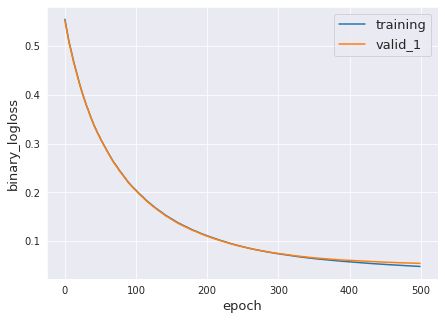

In [20]:
md.plot_train_info()

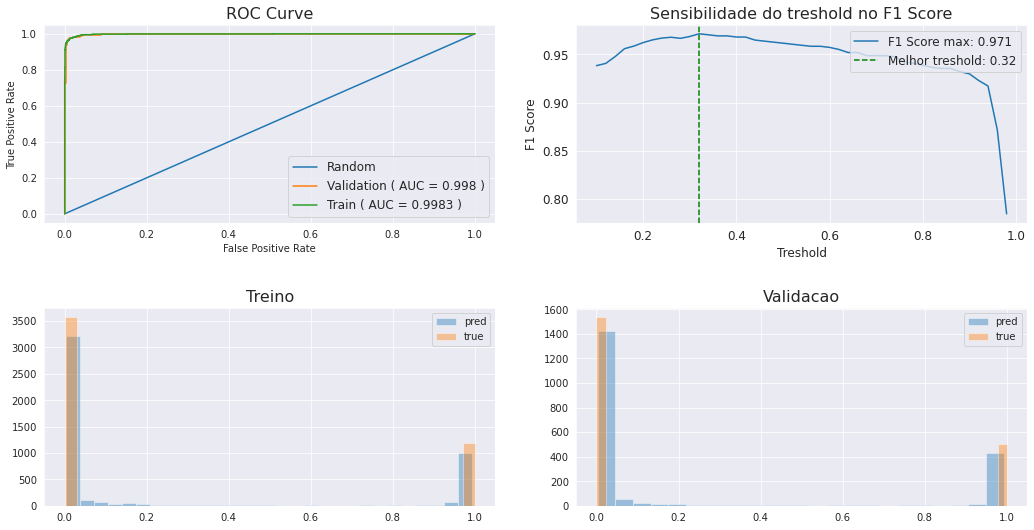

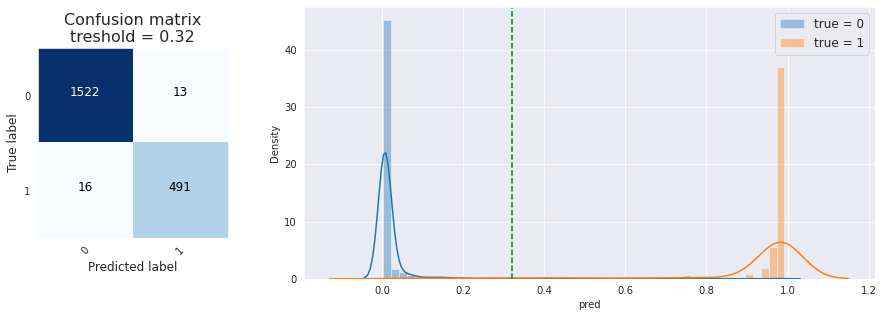


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1535
           1       0.97      0.97      0.97       507

    accuracy                           0.99      2042
   macro avg       0.98      0.98      0.98      2042
weighted avg       0.99      0.99      0.99      2042



In [21]:
ytrain_pred = md.predict(x_train)
yval_pred = md.predict(x_test)

md.evaluation_plots(y_train.values, ytrain_pred, y_test.values, yval_pred)

In [22]:
# shap
df_shap = md.init_shap(x_test)
df_shap.head()

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
0,0.0,0.000138,0.0,0.0,0.012412,-0.185823,-0.000210,0.0,0.008941,0.0,...,0.0,0.0,-0.000534,-0.019352,-0.000235,0.0,0.0,0.0,-0.001622,0.0
1,0.0,0.000138,0.0,0.0,0.002657,-0.182887,-0.000147,0.0,0.008389,0.0,...,0.0,0.0,-0.000418,-0.025218,-0.000326,0.0,0.0,0.0,-0.001651,0.0
2,0.0,0.000089,0.0,0.0,0.002386,-0.149104,-0.000147,0.0,0.009431,0.0,...,0.0,0.0,-0.000427,0.918198,-0.000326,0.0,0.0,0.0,-0.004118,0.0
3,0.0,0.000089,0.0,0.0,0.003073,-0.181912,-0.000183,0.0,0.010941,0.0,...,0.0,0.0,-0.000488,-0.016468,-0.000326,0.0,0.0,0.0,-0.001647,0.0
4,0.0,0.000509,0.0,0.0,0.002893,-0.056636,-0.000646,0.0,0.008855,0.0,...,0.0,0.0,0.020901,-0.004824,-0.000303,0.0,0.0,0.0,0.030471,0.0


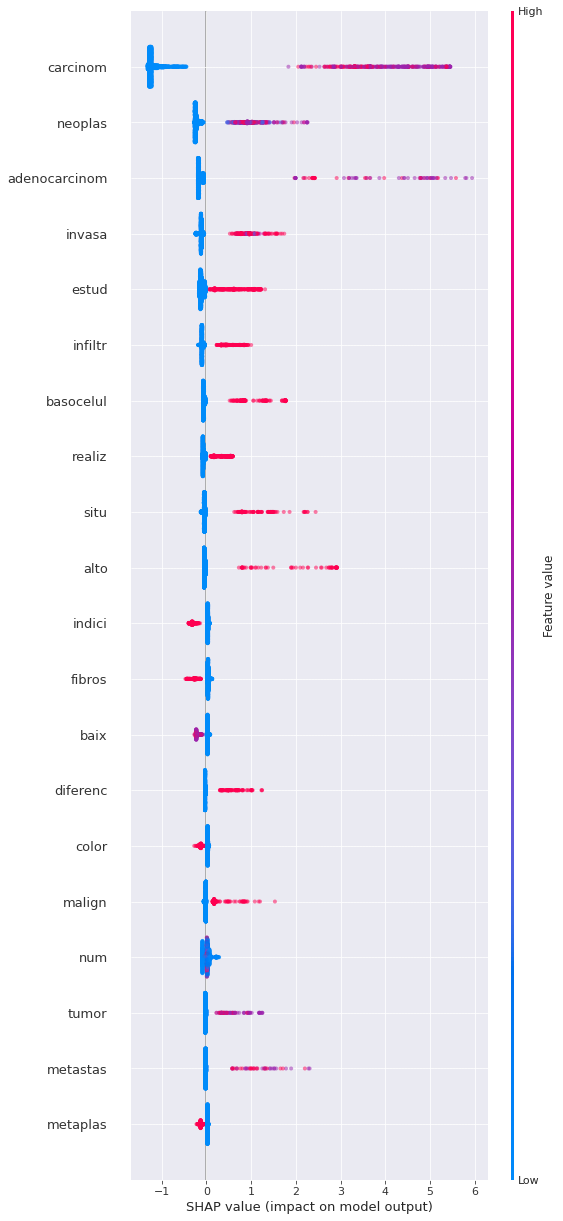

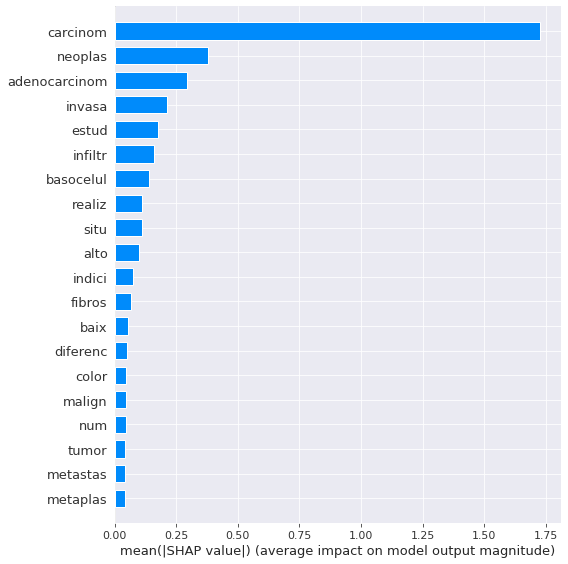

In [23]:
importance = md.shap_importance(x_test)

In [24]:
importance

carcinom         1.725975
neoplas          0.378428
adenocarcinom    0.291800
invasa           0.214171
estud            0.176145
                   ...   
intestinal       0.000000
intens           0.000000
inflamator       0.000000
hor              0.000000
acentu           0.000000
Length: 250, dtype: float64

# Resultados da base anual

In [25]:
# test-set definition
laudos['dataliberacao'] = pd.to_datetime(laudos['dataliberacao'])
list_dfyear = GetYearBasis(laudos)
df_2014 = list_dfyear[0]
df_2015 = list_dfyear[1]
df_2016 = list_dfyear[2]
df_2017 = list_dfyear[3]
df_2018 = list_dfyear[4]
df_2019 = list_dfyear[5]

# checking shapes
print('Shape of df_2014: ', df_2014.shape)
print('Shape of df_2015: ', df_2015.shape)
print('Shape of df_2016: ', df_2016.shape)
print('Shape of df_2017: ', df_2017.shape)
print('Shape of df_2018: ', df_2018.shape)
print('Shape of df_2019: ', df_2019.shape)

Shape of df_2014:  (5983, 7)
Shape of df_2015:  (33156, 7)
Shape of df_2016:  (34349, 7)
Shape of df_2017:  (34527, 7)
Shape of df_2018:  (34675, 7)
Shape of df_2019:  (32843, 7)


In [138]:
year_list = ['2014','2015','2016','2017','2018','2019']
df_list = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019]

# range(len(year_list))
for year in range(len(year_list)):
    dataset_year = df_list[year].reset_index(drop=True)
    dataset_year = dataset_year[(dataset_year['texto'] != '') & (dataset_year['texto'] !='<NA>')]
    x_test = pipe.transform(dataset_year)
    
    y_pred_test = md.predict(x_test)
    pred_df = pd.DataFrame(y_pred_test, columns=['prediction_score'])
    print('shape of predictions df: ', pred_df.shape)
    pred_df['rgh'] = dataset_year['rgh'].to_list()
    pred_df['laudo'] = dataset_year['laudo'].to_list()
    print('shape of merged df: ', pred_df.shape)
    
    positive_reflist = np.where(y_pred_test >= 0.32)
    pred_df['prediction'] = 0
    pred_df['prediction'].iloc[list(positive_reflist[0])] = 1
    #pred_df.to_parquet('s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_'+str(year_list[year])+'.parquet')
    #print('saved in s3')
    print('-'*60)
    print('')

pred_df

shape of predictions df:  (5980, 1)
shape of merged df:  (5980, 3)
saved in s3
------------------------------------------------------------

shape of predictions df:  (33156, 1)
shape of merged df:  (33156, 3)
saved in s3
------------------------------------------------------------

shape of predictions df:  (34349, 1)
shape of merged df:  (34349, 3)
saved in s3
------------------------------------------------------------

shape of predictions df:  (34526, 1)
shape of merged df:  (34526, 3)
saved in s3
------------------------------------------------------------

shape of predictions df:  (34675, 1)
shape of merged df:  (34675, 3)
saved in s3
------------------------------------------------------------

shape of predictions df:  (32843, 1)
shape of merged df:  (32843, 3)
saved in s3
------------------------------------------------------------



,prediction_score,rgh,laudo,prediction
0,0.980910,15079600,H19-001989,1
1,0.991103,15257130,H19-026991,1
2,0.003786,15040290,H19-012600,0
3,0.938472,15347650,H18-036938,1
4,0.988682,15363420,H18-036873,1
...,...,...,...,...
32838,0.005390,15934850,H19-040755,0
32839,0.005667,16008018,H19-040756,0
32840,0.005786,16008411,H19-040765,0
32841,0.005160,16008123,H19-040766,0


In [26]:
# reading output dfs from s3
output_2014 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2014.parquet')
output_2015 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2015.parquet')
output_2016 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2016.parquet')
output_2017 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2017.parquet')
output_2018 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2018.parquet')
output_2019 = wr.s3.read_parquet(path='s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_2019.parquet')

In [43]:
# estatísticas de 2014
print('2014')
print('número total de casos avaliados: ', len(output_2014))
output_2014['prediction'].value_counts(normalize=True)

2014
número total de casos avaliados:  5980


0    0.610535
1    0.389465
Name: prediction, dtype: float64

In [44]:
# estatísticas de 2015
print('2015')
print('número total de casos avaliados: ', len(output_2015))
output_2015['prediction'].value_counts(normalize=True)

2015
número total de casos avaliados:  33156


0    0.612137
1    0.387863
Name: prediction, dtype: float64

In [45]:
# estatísticas de 2016
print('2016')
print('número total de casos avaliados: ', len(output_2016))
output_2016['prediction'].value_counts(normalize=True)

2016
número total de casos avaliados:  34349


0    0.612332
1    0.387668
Name: prediction, dtype: float64

In [46]:
# estatísticas de 2017
print('2017')
print('número total de casos avaliados: ', len(output_2017))
output_2017['prediction'].value_counts(normalize=True)

2017
número total de casos avaliados:  34526


0    0.613509
1    0.386491
Name: prediction, dtype: float64

In [47]:
# estatísticas de 2018
print('2018')
print('número total de casos avaliados: ', len(output_2018))
output_2018['prediction'].value_counts(normalize=True)

2018
número total de casos avaliados:  34675


0    0.615429
1    0.384571
Name: prediction, dtype: float64

In [48]:
# estatísticas de 2019
print('2019')
print('número total de casos avaliados: ', len(output_2019))
output_2019['prediction'].value_counts(normalize=True)

2019
número total de casos avaliados:  32843


0    0.622142
1    0.377858
Name: prediction, dtype: float64

# Salvando datasets com texto e predição - revisão médica

In [61]:
# # merge dos dataframes para comparação texto/predição em 2014
# df_compare = pd.merge(left=output_2019, right=laudos, on='laudo', how='inner')
# df_compare = df_compare[['laudo','rgh_x','texto','prediction_score','prediction']]
# df_compare.rename(columns={'rgh_x':'rgh'}, inplace=True)
# df_compare.to_parquet('s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_texto_2014.parquet')

# # merge dos dataframes para comparação texto/predição em 2015
# df_compare = pd.merge(left=output_2019, right=laudos, on='laudo', how='inner')
# df_compare = df_compare[['laudo','rgh_x','texto','prediction_score','prediction']]
# df_compare.rename(columns={'rgh_x':'rgh'}, inplace=True)
# df_compare.to_parquet('s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_texto_2015.parquet')

# # merge dos dataframes para comparação texto/predição em 2016
# df_compare = pd.merge(left=output_2019, right=laudos, on='laudo', how='inner')
# df_compare = df_compare[['laudo','rgh_x','texto','prediction_score','prediction']]
# df_compare.rename(columns={'rgh_x':'rgh'}, inplace=True)
# df_compare.to_parquet('s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_texto_2016.parquet')

# # merge dos dataframes para comparação texto/predição em 2017
# df_compare = pd.merge(left=output_2019, right=laudos, on='laudo', how='inner')
# df_compare = df_compare[['laudo','rgh_x','texto','prediction_score','prediction']]
# df_compare.rename(columns={'rgh_x':'rgh'}, inplace=True)
# df_compare.to_parquet('s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_texto_2017.parquet')

# # merge dos dataframes para comparação texto/predição em 2018
# df_compare = pd.merge(left=output_2019, right=laudos, on='laudo', how='inner')
# df_compare = df_compare[['laudo','rgh_x','texto','prediction_score','prediction']]
# df_compare.rename(columns={'rgh_x':'rgh'}, inplace=True)
# df_compare.to_parquet('s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_texto_2018.parquet')

# # merge dos dataframes para comparação texto/predição em 2019
# df_compare = pd.merge(left=output_2019, right=laudos, on='laudo', how='inner')
# df_compare = df_compare[['laudo','rgh_x','texto','prediction_score','prediction']]
# df_compare.rename(columns={'rgh_x':'rgh'}, inplace=True)
# df_compare.to_parquet('s3://br-accamargo-rawdata-dev/predicoes_anuais/predicao_texto_2019.parquet')

In [62]:
# checking some examples
df_compare = pd.merge(left=output_2015, right=laudos, on='laudo', how='inner')

In [63]:
pos_list_merged = np.where(df_compare['prediction'] == 1)
pos_list_merged[0]

array([    2,     3,     8, ..., 33149, 33150, 33154])

In [64]:
print('exemplos positivos: \n')
for i in pos_list_merged[0][0:5]:
    print(df_compare['texto'].iloc[i], '\n')
    print('-'*10, '\n')

exemplos positivos: 

Produto de ressecção de lesão de pele de região parietal direita (1ª à 5ª congelações):
* Carcinoma epidermóide bem diferenciado, ulcerado, invasivo.
. Margens cirúrgicas de 12-03 horas, 03-06 horas, 06-09 horas, 09-12 horas e profunda (1ª à 5ª congelações): livres de neoplasia.
. Pele adjacente: áreas de ulceração da epiderme associado a processo inflamatório crônico  e agudo e hialinização intensa da derme.

Notas: 
1- Foram realizados 05 exames per-operatórios de congelação, cujo material encontra-se em nossos arquivos.
2- Foram consideradas as margens avaliadas nos preparados do exame per-operatório.
 

---------- 


1 Grande omento 
*Infiltração por adenocarcinoma, de padrão seroso e células claras em meio a necrose	
	. medida do maior implante: 3 cm 	

2 Biópsia de peritônio pélvico 
* Infiltração por adenocarcinoma, de padrão seroso e células claras em meio a fibrose.

3 Saco herniário
* Tecido fibroconjuntivo com ectasias vasculares e infiltração por adeno

In [65]:
neg_list_merged = [i for i in df_compare.index if i not in pos_list_merged[0]]
print(neg_list_merged[0:5], '\n')
print('exemplos negativos: \n')
for i in neg_list_merged[0:5]:
    print(df_compare['texto'].iloc[i], '\n')
    print('-'*10, '\n')

[0, 1, 4, 5, 6] 

exemplos negativos: 


1 Pólipo de reto
* Adenoma tubular com displasia de baixo grau.

 

---------- 


1 Pólipo duodeno
* Fragmentos de mucosa duoedenal com discreta hiperplasia das glândulas de Brunner.

2 Biópsia de corpo e antro

* Gastrite crônica leve, em mucosa de padrão corpo e antro, com as seguintes características:
	. Atividade inflamatória: ausente
	. Atrofia glandular: presente e discreta
	. Metaplasia intestinal: presente, completa e sem atipias
	. Outros achados: fibrose leve da lâmina própria.
* A pesquisa de Helicobacter pylori pela coloração de Giemsa resultou negativa
 

---------- 

1 Biópsia de mama esquerda 
* Papiloma intraductal
. Microcalcificações intraluminais
. Hiperplasia ductal usual
. Adenose esclerosante
. Alterações fibroadenomatoides
. Alteração de células colunares sem atipias
. Cistificação de ductos

Nota: No material examinado não há indícios morfológicos de malignidade.
 

---------- 

1 Biópsia de válvula íleo-cecal:
* Adenoma 